In [ ]:
pip install git+https://github.com/the-deep/reports_generator --quiet

In [1]:
import sys
sys.path.append('..')

import os
from typing import List
import json
import pandas as pd
from tqdm import tqdm

from nltk import data
tokenizer = data.load('tokenizers/punkt/english.pickle')

from ast import literal_eval
from collections import Counter
from reports_generator import RerportsGenerator
import boto3

## I. sentences from raw documents (after manually filtering relevant documents)

In [2]:
def flatten(input_list: List[List[str]]):
    return [item for sublist in input_list for item in sublist]# for item in subsublist]

RAW_FILES_PATH = os.path.join('data', 'raw')
file_paths = os.listdir(RAW_FILES_PATH)

def preprocess_file(file_path):
    file = json.load(open(os.path.join(RAW_FILES_PATH, file_path)))
    file = flatten(file)
    file = [tokenizer.tokenize(paragraph) for paragraph in file]
    sentences = flatten(file)
    return sentences

text_list = flatten([preprocess_file(file_path) for file_path in file_paths])

In [6]:
df = pd.DataFrame(text_list, columns=['excerpt'])
df

,excerpt
0,DEC Pakistan floods appeal raises £13.5 millio...
1,The Disasters Emergency Committee’s (DEC) appe...
2,The total includes £5 million matched pound-fo...
3,The DEC launched the appeal on Thursday to hel...
4,"Appeal films presented on ITV, Channel 4, Chan..."
...,...
480,In order to ensure that aid reaches everyone a...
481,What we are doing NOW & Where:\nSupporting the...
482,Your donations will be vital in changing and s...
483,To support our medical response activities in ...


## II. Model prediction of sentences

In [16]:
client = boto3.session.Session().client("sagemaker-runtime", region_name='us-east-1')

all_outputs = []

for i in tqdm(range(df.shape[0])):
    test_tmp = df[i:i+1]
    inputs = test_tmp[['excerpt']]  
    inputs['return_type'] = "default_analyis" 
    
    backbone_inputs_json = inputs.to_json(orient="split")

    try:
        response = client.invoke_endpoint(
            EndpointName='test-all-models-rsh',
            Body=backbone_inputs_json,
            ContentType="application/json; format=pandas-split",
        )
        output = response["Body"].read().decode("ascii")
    except Exception:
        output = 'error'
    #output = literal_eval(output)
    
    all_outputs.append(output)

100%|██████████| 485/485 [01:49<00:00,  4.44it/s]


In [20]:
labels = []
threshold_ratio = 1.1

for one_output in all_outputs:
    output = literal_eval(one_output)["raw_predictions"]
    sector_preds = [
        f"sectors->{item}"
        for item, ratio in literal_eval(one_output)["raw_predictions"]["sectors"][
            0
        ].items()
        if ratio > threshold_ratio
    ]
    subpilllars_preds = [
        f"subpillars->{item}"
        for item, ratio in literal_eval(one_output)["raw_predictions"]["subpillars"][
            0
        ].items()
        if ratio > threshold_ratio
    ]
    labels.append(sector_preds + subpilllars_preds)

label_counts = dict(Counter(flatten(labels)).most_common(30))

In [26]:
df['predictions'] = labels
df = df[df.predictions.apply(lambda x: len(x)>0)]
df

<ipython-input-26-a07a5db5c05e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = [label for label in labels if len(label)>0]


,excerpt,predictions
0,DEC Pakistan floods appeal raises £13.5 millio...,"[sectors->Food Security, subpillars->Shock/Eve..."
1,The Disasters Emergency Committee’s (DEC) appe...,"[sectors->Food Security, sectors->Nutrition]"
2,The total includes £5 million matched pound-fo...,[subpillars->Capacities & Response->Internatio...
4,"Appeal films presented on ITV, Channel 4, Chan...",[subpillars->Capacities & Response->Internatio...
5,DEC Director of Programmes & Accountability Ma...,"[sectors->Health, subpillars->Impact->Impact O..."
...,...,...
479,Our Emergency Response:\nDoctors Worldwide UK ...,"[sectors->Health, subpillars->Capacities & Res..."
481,What we are doing NOW & Where:\nSupporting the...,"[sectors->Health, sectors->Nutrition, sectors-..."
482,Your donations will be vital in changing and s...,[subpillars->Priority Interventions->Expressed...
483,To support our medical response activities in ...,"[sectors->Health, subpillars->Priority Interve..."


In [43]:
df.to_csv('pakistan_df.csv.gz', index=None, compression='gzip')

## III. Summaries

In [ ]:
data = pd.read_csv('pakistan_df.csv.gz', compression='gzip')
data['predictions'] = data['predictions'].apply(literal_eval)

summarizer = ReportsGenerator()   
important_labels = [label for label, count in label_counts.items() if count>=15]

summarized_text = {}
for one_label in important_labels:
    data_one_label = data[data['predictions'].apply(lambda x: one_label in x)].excerpt.tolist()
    summary = summarizer(data_one_label)
    summarized_text[one_label] = summary
    print(one_label)
    print(summary)

with open('summary_pakistan.json', 'w') as fp:
    json.dump(summary, fp)

## IV. Vizu

In [21]:
from vizualization import get_barplots

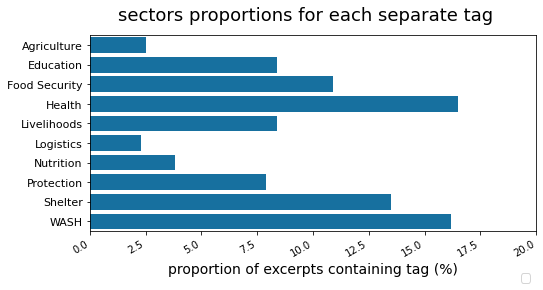

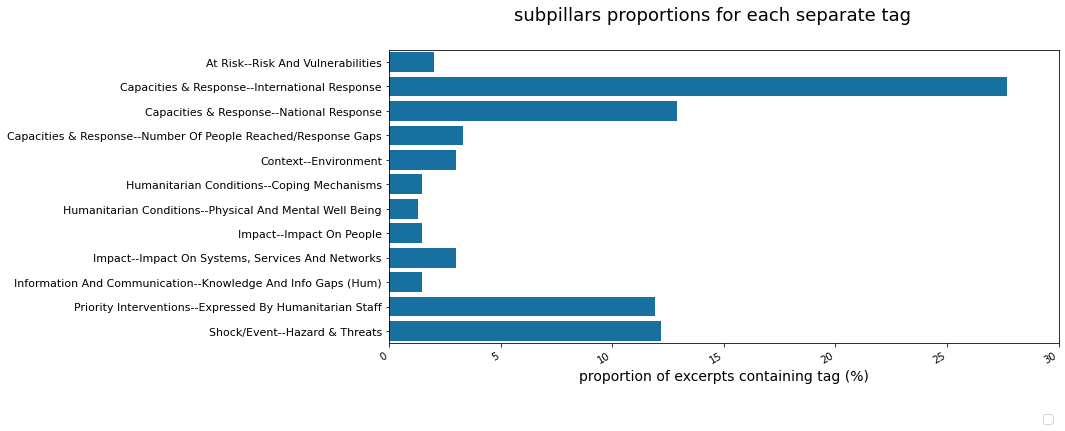

In [37]:
df['predictions_modified'] = df['predictions'].apply(lambda x: ['--'.join(item.split('->')[1:]) for item in x])
df['sectors'] = df['predictions_modified'].apply(lambda x: [item for item in x if '--' not in item])
df['subpillars'] = df['predictions_modified'].apply(lambda x: [item for item in x if '--' in item])

get_barplots(
    col=df.sectors,
    col_name="sectors",
    image_name="sectors",
    min_percentage=1,
)

get_barplots(
    col=df.subpillars,
    col_name="subpillars",
    image_name="subpillars",
    min_percentage=1,
)